In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from alibi.datasets import fetch_imagenet
from sklearn.datasets import load_iris, load_diabetes
%matplotlib inline

In [2]:
%set_env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
tf.test.is_gpu_available()

True

In [466]:
from alibi.utils.approximation_methods import approximation_parameters
from alibi.confidence.model_linearity import LinearityMeasure

In [463]:
def alpha_rand(x, tot_feats, alpha, permute=True):
    if permute:
        mask = np.random.permutation(np.concatenate((np.zeros(tot_feats - alpha), np.ones(alpha)))).reshape(x.shape)
    else:
        mask = np.concatenate((np.zeros(tot_feats - alpha), np.ones(alpha))).reshape(x.shape)
    return mask

In [553]:
!git branch 

* integrated-gradients-2
  master


In [530]:
def plot_saturation_curve(x, label, nb_steps, model, 
                          batch_size=1000, how='interpolation', permute=True, plot_df=False):
    
    baselines = np.zeros(x.shape)
    nb_samples = x.shape[0]
    reshape_as = (nb_steps, nb_samples) 
    step_sizes_func, alphas_func = approximation_parameters('gausslegendre')
    step_sizes, alphas = step_sizes_func(nb_steps), alphas_func(nb_steps)  

    if how == 'interpolation':
        paths = np.concatenate([baselines + alphas[i] * (x - baselines) for i in range(nb_steps)], axis=0)
    elif how == 'random_feats':
        tot_feats = reduce(lambda x, y: x * y, list(x.shape))
        paths = np.concatenate([baselines + alpha_rand(x, tot_feats, int(alphas[i] * tot_feats), permute=permute) * (x - baselines) for i in range(nb_steps)], axis=0)
    target_paths = np.concatenate([label for _ in range(nb_steps)], axis=0)

    lm = LinearityMeasure(nb_samples=10, epsilon=0.04, agg='pairwise')
    lm.fit(paths)
    pred_list, lin_list = [], []
    nb_batches = np.ceil(len(paths) / batch_size).astype(int)
    for b in range(nb_batches):
        batch = paths[b * batch_size: (b + 1) * batch_size]
        probas = model(tf.dtypes.cast(batch, model.input.dtype)).numpy()
        pred = np.diag(probas[:, target_paths])
        pred_list.append(pred)
        # TODO calculate linearity
        lins = lm.score(model, batch)
        lin_list.append(lins)
    paths_preds = np.concatenate(pred_list, axis=0).reshape(reshape_as)
    paths_lins = np.concatenate(lin_list, axis=0).reshape(reshape_as)
    
    print(paths_lins.shape)
    df_preds = pd.DataFrame(paths_preds, columns=['proba_{}'.format(i) for i in range(nb_samples)])
    df_preds['alphas'] = alphas / max(alphas)
    df_preds.set_index('alphas', inplace=True)
    
    df_lin = pd.DataFrame(paths_lins, columns=['linearity_{}'.format(i) for i in range(nb_samples)])
    df_lin['alphas'] = alphas / max(alphas)
    df_lin.set_index('alphas', inplace=True)    
    if plot_df:
        df_preds.plot()
    
    return df_preds, df_lin, paths

In [498]:
lm = LinearityMeasure(nb_samples=0)
lm.fit(X_train)

In [506]:
features_range = np.asarray([np.zeros(x.shape[0]), np.ones(x.shape[0])]).T

In [513]:
linearity_measure(model, np.zeros(x.shape), X_train=x, epsilon=0.001)

array([0.08608532, 0.08262309, 0.10064975, 0.09029256, 0.0868296 ,
       0.08822641, 0.08562608, 0.08257526, 0.09024088, 0.09354826,
       0.08675474, 0.09250273, 0.09114699, 0.09568189, 0.09040993,
       0.083755  , 0.08406059, 0.08784564, 0.078799  , 0.09335609,
       0.08880923, 0.08993843, 0.09058249, 0.08853659, 0.09048696,
       0.09074292, 0.08883332, 0.09408507, 0.08840904, 0.08997014,
       0.08996831, 0.09414225, 0.09369322, 0.09295072, 0.082501  ,
       0.08693241, 0.09047274, 0.09054329, 0.08848981, 0.08426871,
       0.08408919, 0.08606016, 0.09061858, 0.09001198, 0.09499568,
       0.08998685, 0.097647  , 0.0945307 , 0.09705749, 0.08605793,
       0.09674777, 0.08705922, 0.09952758, 0.08868048, 0.09536007,
       0.09232794, 0.08626178, 0.09209324, 0.09730748, 0.09835101,
       0.09295947, 0.09821894, 0.08701461, 0.09333112, 0.08551089,
       0.09857955, 0.09146355, 0.09106109, 0.0886332 , 0.08717165,
       0.09013332, 0.08795691, 0.08321964, 0.08290635, 0.08396

In [531]:
df_inter, df_lin, paths = plot_saturation_curve(x, label, 50, model, how='random_feats')

(50, 100)


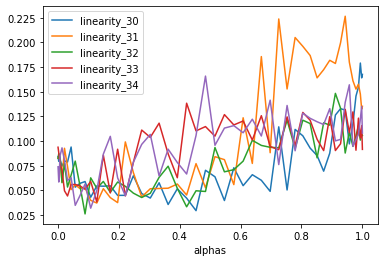

In [532]:
df_lin[['linearity_{}'.format(i) for i in range(30, 35)]].plot()

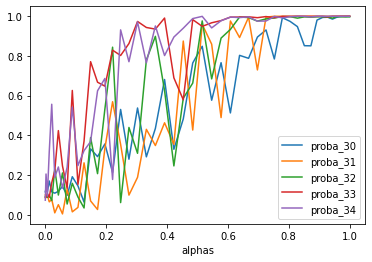

In [533]:
df_inter[['proba_{}'.format(i) for i in range(30, 35)]].plot()

In [346]:
probas = np.random.rand(6,3)

In [347]:
label = [0 for i in range(2)] + [1 for j in range(2)] + [2 for j in range(2)]

In [348]:
probas

array([[0.0922033 , 0.9211942 , 0.17510147],
       [0.05655539, 0.12004847, 0.52872185],
       [0.56810658, 0.34367502, 0.32451034],
       [0.99145758, 0.73099709, 0.92964368],
       [0.27413529, 0.08600638, 0.91499253],
       [0.17811224, 0.79128163, 0.99132546]])

In [349]:
label

[0, 0, 1, 1, 2, 2]

In [352]:
np.diag(probas[:, label])

array([0.0922033 , 0.05655539, 0.34367502, 0.73099709, 0.91499253,
       0.99132546])

# TF model

In [238]:
def define_model(X_train, model_arch, ff_activation='relu', nb_classes=3):
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    if model_arch == 'conv':
        x = Conv2D(64, 2, padding='same', activation='relu', name='conv1')(inputs)
        x = MaxPooling2D(pool_size=(2,2), name='maxpool1')(x)
        x = Dropout(.3)(x)
        x = Conv2D(32, 2, padding='same', activation='relu', name='conv2')(x)
        x = MaxPooling2D(pool_size=(2, 2), name='maxpool2')(x)
        x = Dropout(.3)(x)
        x = Flatten(data_format='channels_last')(x)
        x = Dense(256, activation='relu', name='linear1')(x)
        x = Dropout(.5)(x)
        logits = Dense(nb_classes, name='linear2')(x)
        
    elif model_arch == 'ff':
        x = Dense(256, activation=ff_activation, name='linear1')(inputs)
        logits = Dense(nb_classes, name='linear2')(x)

    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

# Iris

In [126]:
iris = load_iris()

In [127]:
perm = np.random.permutation(range(len(X_iris))).tolist()

In [292]:

X_iris = iris.data
X_iris = X_iris[perm]
labels = iris.target
labels = labels[perm]

y_iris = to_categorical(labels)
X_train, labels_train = X_iris[:int(0.7 * X_iris.shape[0])], labels[:int(0.7 * X_iris.shape[0])]
X_test, labels_test = X_iris[int(0.7 * X_iris.shape[0]):], labels[int(0.7 * X_iris.shape[0]):]
y_train = to_categorical(labels_train, 3)
y_test = to_categorical(labels_test, 3)


In [293]:
labels_train

array([0, 1, 2, 0, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2])

In [294]:
filepath = './model_iris'#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    model = define_model(X_iris, 'ff', ff_activation='relu')
    # train model
    model.fit(X_train,
              y_train,
              epochs=100,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

OSError: SavedModel file does not exist at: ./model_iris/model.h5/{saved_model.pbtxt|saved_model.pb}

In [131]:
x = X_test[0].reshape(1, -1)
label = labels_test[0]
x.shape

(1, 4)

(50, 4)


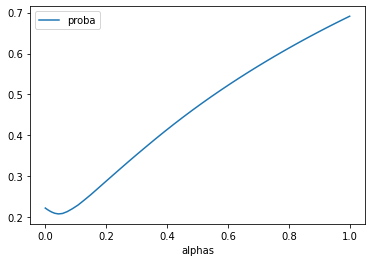

In [132]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='interpolation')

(50, 4)


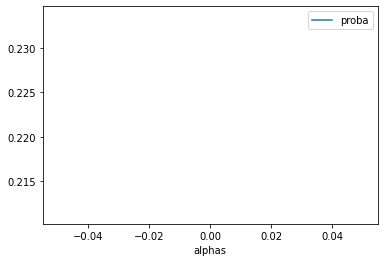

In [133]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats')

(50, 4)


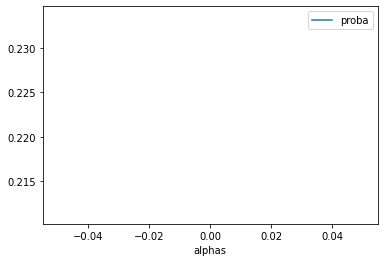

In [134]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats', permute=False)

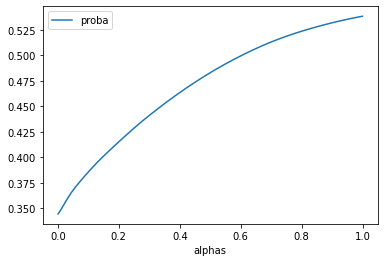

In [102]:
plot_saturation_curve(x, label, model)


In [103]:
model(x)

<tf.Tensor: id=59714, shape=(1, 3), dtype=float64, numpy=array([[0.06966999, 0.53826848, 0.39206153]])>

In [132]:
model_arch ='conv' #  'ff'

# Mnist

In [534]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, labels_train = train
X_test, labels_test = test
if model_arch == 'conv':
    X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
    X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
elif model_arch == 'ff':
    X_train = X_train.reshape(-1, 28 * 28).astype('float64') / 255
    X_test = X_test.reshape(-1, 28 * 28).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [535]:
model_arch = 'conv'
load_tf_model = True

In [536]:
filepath = './model_{}_mnist/'.format(model_arch)#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
else:
    # define model
    model = define_model(X_train, model_arch, nb_classes=10)
    # train model
    model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

In [537]:
i = 11
n_samples = 100
x = X_test[i: i + n_samples]
label = labels_test[i: i + n_samples]
#label

In [538]:
#plt.imshow(np.squeeze(x))

In [541]:
df_inter_preds, df_inter_lins, paths = plot_saturation_curve(x, label, 50, model, how='interpolation')

(50, 100)


In [542]:
df_perm_preds, df_perm_lins, paths = plot_saturation_curve(x, label, 50, model, how='random_feats')

(50, 100)


In [543]:
df_noperm_preds, df_noperm_lins, paths = plot_saturation_curve(x, label, 50, model, how='random_feats', permute=False)

(50, 100)


In [453]:
df_perm

,proba_0,proba_1,proba_2,proba_3,proba_4,proba_5,proba_6,proba_7,proba_8,proba_9,...,proba_90,proba_91,proba_92,proba_93,proba_94,proba_95,proba_96,proba_97,proba_98,proba_99
alphas,,,,,,,,,,,,,,,,,,,,,
0.000567,0.086636,0.096039,0.088670,0.166834,0.359702,0.096039,0.115789,0.086827,0.099209,0.096039,...,0.096970,0.094556,0.099209,0.096039,0.096039,0.084274,0.166834,0.096039,0.099209,0.066422
0.002986,0.086636,0.080404,0.096970,0.166834,0.092816,0.096039,0.056270,0.143193,0.099209,0.119111,...,0.096970,0.112375,0.100201,0.096039,0.096039,0.090718,0.166834,0.096039,0.099209,0.047449
0.007327,0.061846,0.096039,0.095368,0.161179,0.156575,0.096039,0.112649,0.018605,0.099209,0.096039,...,0.096970,0.094556,0.150035,0.063386,0.095991,0.102234,0.192868,0.098678,0.091459,0.058393
0.013576,0.078964,0.054532,0.048552,0.166834,0.093734,0.045348,0.411326,0.044425,0.104438,0.128492,...,0.096782,0.181459,0.081684,0.048225,0.044405,0.011420,0.226594,0.073724,0.099209,0.066422
0.021707,0.034136,0.096039,0.067796,0.166834,0.018321,0.020738,0.149026,0.087180,0.096951,0.096039,...,0.059767,0.480406,0.069910,0.046480,0.078384,0.013352,0.101923,0.010737,0.154169,0.032840
0.031690,0.016148,0.020193,0.038840,0.120988,0.095595,0.051580,0.453692,0.147446,0.118232,0.045924,...,0.029320,0.104763,0.146029,0.096039,0.135112,0.040984,0.146820,0.096160,0.054866,0.003706
0.043485,0.062549,0.084977,0.039383,0.101327,0.012359,0.031385,0.210204,0.083778,0.027893,0.049805,...,0.037337,0.026683,0.098653,0.070730,0.039466,0.084106,0.124457,0.027830,0.091521,0.030785
0.057048,0.042750,0.031440,0.019508,0.045742,0.088357,0.046323,0.165495,0.034292,0.133968,0.088433,...,0.068689,0.132940,0.096130,0.016574,0.018699,0.112330,0.060649,0.051370,0.133594,0.030675
0.072326,0.017764,0.055530,0.096176,0.131339,0.060585,0.019651,0.483412,0.159662,0.093092,0.047310,...,0.037116,0.574209,0.055465,0.012736,0.011144,0.040156,0.098898,0.107069,0.124902,0.004483


# Cifar

In [544]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, labels_train = train
X_test, labels_test = test
labels_train, labels_test = labels_train.flatten(), labels_test.flatten()
if model_arch == 'conv':
    X_train = X_train.reshape(-1, 32, 32, 3).astype('float64') / 255
    X_test = X_test.reshape(-1, 32, 32, 3).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
elif model_arch == 'ff':
    X_train = X_train.reshape(-1, 32 * 32 * 3).astype('float64') / 255
    X_test = X_test.reshape(-1, 32 * 32 * 3).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [545]:
model_arch = 'conv'
load_tf_model = True

In [546]:
filepath = './model_{}_cifar/'.format(model_arch)#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
else:
    # define model
    model = define_model(X_train, model_arch, nb_classes=10)
    # train model
    model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

In [547]:
i = 11
n_samples = 100
x = X_test[i: i + n_samples]
label = labels_test[i: i + n_samples]
#label

In [548]:
#plt.imshow(np.squeeze(x))

In [550]:
df_inter_preds, df_inter_lins, paths = plot_saturation_curve(x, label, 50, model, batch_size=500, how='interpolation')

(50, 100)


In [551]:
df_perm_preds, df_perm_lins, paths = plot_saturation_curve(x, label, 50, model, batch_size=500, how='random_feats')

(50, 100)


In [552]:
df_noperm_preds, df_noperm_lins, paths = plot_saturation_curve(x, label, 50, model, batch_size=500, how='random_feats', permute=False)

(50, 100)


# Resnet imagenet

In [223]:
category = 'Persian cat'
image_shape = (224, 224, 3)
data, labels = fetch_imagenet(category, nb_images=10, target_size=image_shape[:2], seed=2, return_X_y=True)
data = data / 255
print('Images shape: {}'.format(data.shape))

Images shape: (10, 224, 224, 3)


In [224]:
model = ResNet50V2(weights='imagenet')

In [233]:
i = 7
x = data[i: i + 1]
label = labels[i]
label

283

(50, 224, 224, 3)


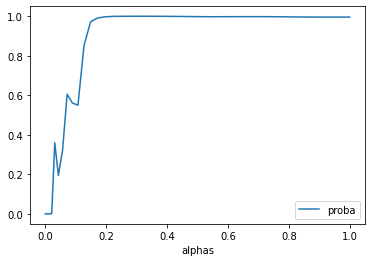

In [234]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='interpolation')

(51, 224, 224, 3)


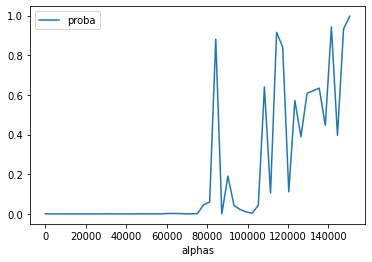

In [235]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats')

(51, 224, 224, 3)


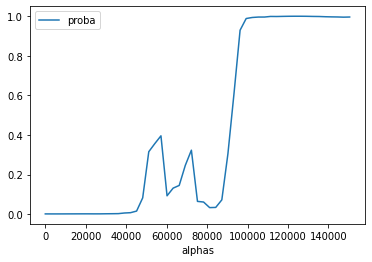

In [236]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats', permute=False)

In [51]:
from functools import reduce

In [56]:
tot_feats = reduce(lambda x, y: x * y, list(x.shape))

In [60]:
step_size = int(tot_feats / 50)

In [67]:
i = 1
alpha = np.random.permutation(np.concatenate((np.ones(i * step_size), np.zeros(tot_feats - i * step_size)))).reshape(x.shape)

In [69]:
alpha * x

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.10588235, 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [ ]:
for i in np.arange(0, 50, 5):
    alpha = alphas[i]
    print(alpha)
    plt.imshow(paths[i])
    plt.show()